In [201]:
import cv2 as cv
from matplotlib import pyplot as plt
import ipywidgets as widgets
import image
import mapa

import numpy as np

import glob
from collections import Counter

In [202]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load image, resize and convert

In [ ]:
img = cv.imread('./images/real01.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
(img_height, img_width, _) = img.shape
img_ratio = 1000 / img_width
#img = cv.resize(img, (1000, int(img_height * img_ratio)), interpolation=cv.INTER_AREA)
#print('h: {}, w: {}'.format(int(img_height * img_ratio), 1000))
print('h: {}, w: {}'.format(img_height, img_width))

In [ ]:
plt.imshow(img)

In [205]:
calibration = np.load('rig/calib.npz')

In [206]:
mtx = calibration['mtx']
dist = calibration['dist']
rvecs = calibration['rvecs']
tvecs = calibration['tvecs']

In [207]:
h, w = img.shape[:2]

In [208]:
newCameraMtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

In [209]:
undistortedImg = cv.undistort(img, mtx, dist, None, newCameraMtx)

In [ ]:
plt.imshow(undistortedImg)

Plot histograms of color spaces, both rgb and hsv

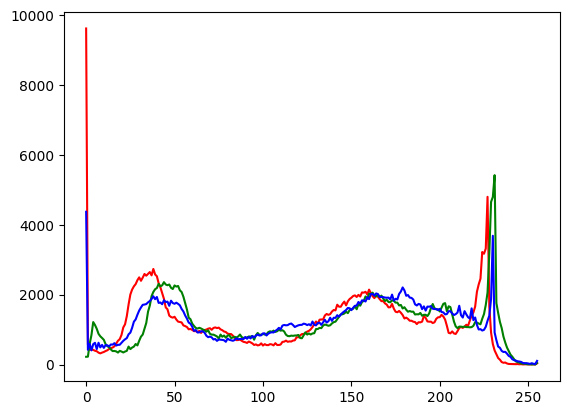

In [211]:
for i, col in enumerate(('r', 'g', 'b')):
    hist_color_rgb = cv.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist_color_rgb, color=col)

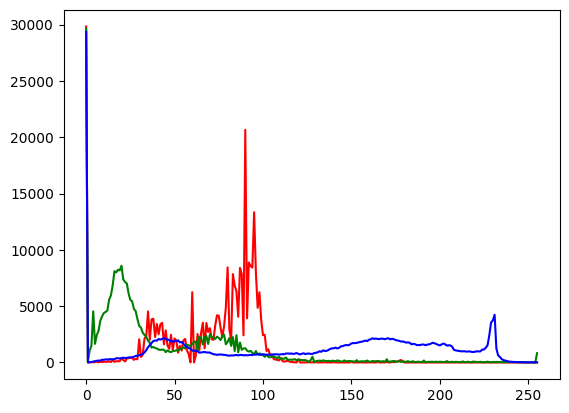

In [212]:
hsv_img = cv.cvtColor(undistortedImg, cv.COLOR_RGB2HSV)
for i, col in enumerate(('r', 'g', 'b')):
    hist_color_hsv = cv.calcHist([hsv_img], [i], None, [256], [0, 256])
    plt.plot(hist_color_hsv, color=col)

# Color tweaking

Find parameters for extracting the mask (high and low colors for range limits) using sliders and looking for the best match.

In [213]:
sliders_low = [widgets.IntSlider(value=0, min=0, max=180 if desc == 'h' else 255, step=1, description=desc) for desc in ('h', 's', 'v')]
sliders_high = [widgets.IntSlider(value=0, min=0, max=180 if desc == 'h' else 255, step=1, description=desc) for desc in ('h', 's', 'v')]
vbox = widgets.VBox([
    widgets.HBox(sliders_low),
    widgets.HBox(sliders_high),
])
vbox

Masking function. It diretly modifies the parameter. There is no need to use the return value

Function that is called when slider value changes

In [214]:
def make_on_change(image):
    def on_hsv_change(_):
        _mask = cv.inRange(
            image,
            (int(sliders_low[0].value), int(sliders_low[1].value), int(sliders_low[2].value)),
            (int(sliders_high[0].value), int(sliders_high[1].value), int(sliders_high[2].value)),
        )
        plt.imshow(_mask)
    return on_hsv_change

In [215]:
make_on_change(None)

<function __main__.make_on_change.<locals>.on_hsv_change(_)>

In [ ]:
[slider.observe(make_on_change(hsv_img)) for slider in sliders_low + sliders_high]

# Create the mask

In [217]:
WHITE_LOWER = (0, 225, 225)
WHITE_UPPER = (180, 255, 255)

BLUE_LOWER = (100, 190, 150)
BLUE_UPPER = (110, 255, 220)

# ROI corner finder

Find maze corners in specific regions of interest

 method reference; to index tPlot corners to a new image

In [218]:
image_class = image.Image(undistortedImg)
image_class.set_areas(
    image.Area(50, 150),
    image.Area(350, 450),
    image.Area(150, 250),
    image.Area(450, 550),
)
image_class.set_origin_points((0, 99), (0, 99))

In [ ]:
plt.imshow(image_class.img)

In [220]:
roi_top_left, roi_top_right, roi_bottom_left, roi_bottom_right = image_class.get_rois()

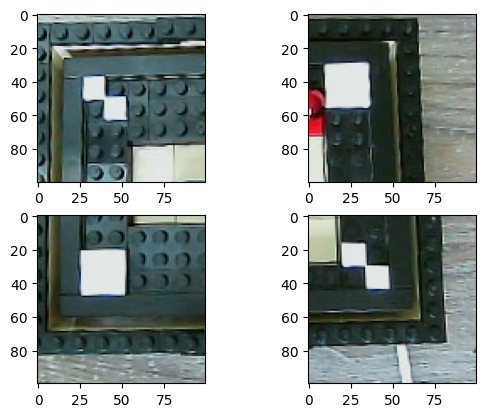

In [221]:
_fig = plt.figure()
_fig.add_subplot(2, 2, 1)
plt.imshow(roi_top_left.img, cmap='gray', vmin=0, vmax=255)
_fig.add_subplot(2, 2, 2)
plt.imshow(roi_top_right.img, cmap='gray', vmin=0, vmax=255)
_fig.add_subplot(2, 2, 3)
plt.imshow(roi_bottom_left.img, cmap='gray', vmin=0, vmax=255)
_fig.add_subplot(2, 2, 4)
plt.imshow(roi_bottom_right.img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
corners = image_class.edge_corner_detect()

In [ ]:
corners

In [224]:
hsv_class = image_class.rgb_to_hsv()

In [ ]:
plt.imshow(hsv_class.img)

In [226]:
CYAN_LOWER = (85, 205, 190)
CYAN_UPPER = (95, 255, 255)

In [227]:
mask_class = hsv_class.make_mask(CYAN_LOWER, CYAN_UPPER)

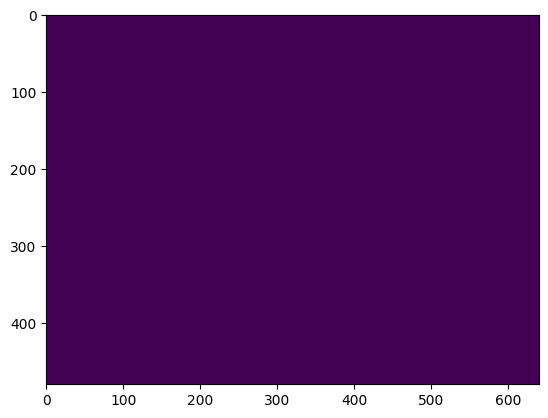

In [228]:
plt.imshow(mask_class.img)

In [ ]:
corners = mask_class.find_corners()

In [ ]:
corners

In [ ]:
debug_class = image_class.copy()

In [ ]:
debug_class.paint_corners(corners)

In [ ]:
plt.imshow(debug_class.img)

In [ ]:
fix1_class = image_class.fix_perspective(corners, (10, 10), (24, 24))

Set new areas and origin points!


In [ ]:
fix1_class.set_areas(
    image.Area(0, 50),
    image.Area(250, 300),
    image.Area(0, 50),
    image.Area(250, 300),
)
fix1_class.set_origin_points(
    (0, 49),
    (0, 49),
)

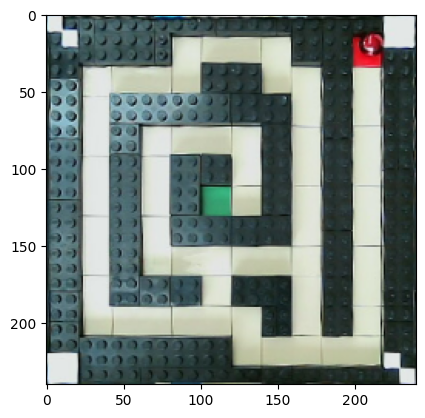

In [ ]:
plt.imshow(fix1_class.img)
plt.savefig('crop.jpg')

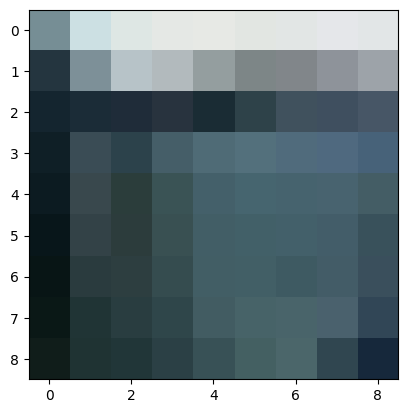

In [ ]:
plt.imshow(fix1_class.img[10:19, 0:9])

In [ ]:
fix1_mapa = mapa.Mapa.from_image(fix1_class.img, (10, 10), (24, 24))

In [ ]:
map_image = image.Image.from_map(fix1_mapa)

In [ ]:
print(fix1_class.img.dtype, fix1_class.img.shape)
#print(type(map_image.img))
print(map_image.img.dtype, map_image.img.shape)

In [ ]:
plt.imshow(map_image.img)
plt.savefig('map.jpg')

In [ ]:
Counter

In [ ]:
kmeans_whole = np.float32(fix1_class.img.reshape((-1, 3)))
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
n_clusters = 6
ret, label, center = cv.kmeans(kmeans_whole, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

In [ ]:
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((fix1_class.img.shape))

In [ ]:
plt.imshow(res2)

In [ ]:
# WIP: Not for use
crop_img = fix1_class.img[10*2:10*3-1, 10*2:10*3-1]
kmeans_img = np.float32(crop_img.reshape((-1, 3)))
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
n_clusters = 1
ret,label,center=cv.kmeans(kmeans_img,n_clusters,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

In [ ]:
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((crop_img.shape))

In [ ]:
center

In [ ]:
plt.imshow(res2)